# UFC 경기 승패 예측 (EDA)

## 1. 라이브러리 임포트 및 데이터 로드

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('UFC.csv')

## 2. 전처리 및 특성 공학

In [3]:
# [전처리] 불필요 컬럼 제거 및 결측치 처리
df.dropna(subset=['winner', 'r_dob', 'b_dob', 'r_stance', 'b_stance', 'r_height', 'b_height'], inplace=True)
df['r_reach'].fillna(df['r_height'], inplace=True)
df['b_reach'].fillna(df['b_height'], inplace=True)
num_cols = df.select_dtypes(include=np.number).columns
df[num_cols] = df[num_cols].fillna(0)

# [특성 공학] 타겟 변수 및 파생 변수 생성
df['winner_is_red'] = (df['winner'] == df['r_name']).astype(int)
df['r_dob'] = pd.to_datetime(df['r_dob'])
df['b_dob'] = pd.to_datetime(df['b_dob'])
df['r_age'] = (pd.to_datetime('today') - df['r_dob']).dt.days / 365.25
df['b_age'] = (pd.to_datetime('today') - df['b_dob']).dt.days / 365.25
df.drop(['r_dob', 'b_dob'], axis=1, inplace=True)

# 차이 특성
df['age_diff'] = df['r_age'] - df['b_age']
df['height_diff'] = df['r_height'] - df['b_height']
df['weight_diff'] = df['r_weight'] - df['b_weight']
df['reach_diff'] = df['r_reach'] - df['b_reach']
df['wins_diff'] = df['r_wins'] - df['b_wins']
df['losses_diff'] = df['r_losses'] - df['b_losses']
df['splm_diff'] = df['r_splm'] - df['b_splm']
df['str_acc_diff'] = df['r_str_acc'] - df['b_str_acc']
df['sapm_diff'] = df['r_sapm'] - df['b_sapm']
df['str_def_diff'] = df['r_str_def'] - df['b_str_def']
df['td_avg_diff'] = df['r_td_avg'] - df['b_td_avg']
df['td_acc_diff'] = df['r_td_avg_acc'] - df['b_td_avg_acc']
df['td_def_diff'] = df['r_td_def'] - df['b_td_def']
df['sub_avg_diff'] = df['r_sub_avg'] - df['b_sub_avg']

# 비율 및 복합 특성
# ratio features (0~1 scaled)
df['sig_str_ratio'] = df['r_splm'] / (df['r_splm'] + df['b_splm'] + 1e-6)
df['td_ratio'] = df['r_td_avg'] / (df['r_td_avg'] + df['b_td_avg'] + 1e-6)
df['str_acc_ratio'] = df['r_str_acc'] / (df['r_str_acc'] + df['b_str_acc'] + 1e-6)
df['td_acc_ratio'] = df['r_td_avg_acc'] / (df['r_td_avg_acc'] + df['b_td_avg_acc'] + 1e-6)

# win ratio features
df['r_win_ratio'] = df['r_wins'] / (df['r_wins'] + df['r_losses'] + 1e-6)
df['b_win_ratio'] = df['b_wins'] / (df['b_wins'] + df['b_losses'] + 1e-6)
df['win_ratio_diff'] = df['r_win_ratio'] - df['b_win_ratio']

# ---------- 추가 파생 특성 ----------
# BMI
df['r_bmi'] = df['r_weight'] / ((df['r_height'] / 100) ** 2 + 1e-6)
df['b_bmi'] = df['b_weight'] / ((df['b_height'] / 100) ** 2 + 1e-6)
df['bmi_diff'] = df['r_bmi'] - df['b_bmi']

# Reach / Height 비율
df['r_reach_ht_ratio'] = df['r_reach'] / (df['r_height'] + 1e-6)
df['b_reach_ht_ratio'] = df['b_reach'] / (df['b_height'] + 1e-6)
df['reach_ht_ratio_diff'] = df['r_reach_ht_ratio'] - df['b_reach_ht_ratio']


# 총 경기 수
df['r_total_fights'] = df['r_wins'] + df['r_losses']
df['b_total_fights'] = df['b_wins'] + df['b_losses']
df['total_fights_diff'] = df['r_total_fights'] - df['b_total_fights']

# ---------- 추가 파생 특성 v3 ----------
# 1) 공격 점수: Striking + Grappling 효율 합
df['r_offense_score'] = df['r_str_eff'] + df['r_grap_eff'] if 'r_str_eff' in df.columns else \
                        (df['r_splm'] * df['r_str_acc']) + (df['r_td_avg'] * df['r_td_avg_acc'])
df['b_offense_score'] = df['b_str_eff'] + df['b_grap_eff'] if 'b_str_eff' in df.columns else \
                        (df['b_splm'] * df['b_str_acc']) + (df['b_td_avg'] * df['b_td_avg_acc'])
df['offense_score_diff'] = df['r_offense_score'] - df['b_offense_score']

# 2) 방어 점수: 타격·테이크다운 방어율 평균
df['r_defense_score'] = (df['r_str_def'] + df['r_td_def']) / 2
df['b_defense_score'] = (df['b_str_def'] + df['b_td_def']) / 2
df['defense_score_diff'] = df['r_defense_score'] - df['b_defense_score']

# 3) 순공격 이득(Net Advantage) = 공격 diff + 방어 diff
df['net_advantage'] = df['offense_score_diff'] + df['defense_score_diff']

# 4) 상호작용 특성: 레드의 공격 vs 블루의 방어, 블루의 공격 vs 레드의 방어
df['str_vs_def_diff'] = (df['r_str_acc'] * df['b_str_def']) - (df['b_str_acc'] * df['r_str_def'])

# 5) 공격/방어 스코어 비율 차이
df['off_def_ratio_diff'] = (df['r_offense_score'] / (df['r_defense_score'] + 1e-6)) - \
                           (df['b_offense_score'] / (df['b_defense_score'] + 1e-6))

# 스탠스 조합 (범주형)weight
df['stance_comb'] = df['r_stance'].astype(str) + '_' + df['b_stance'].astype(str)


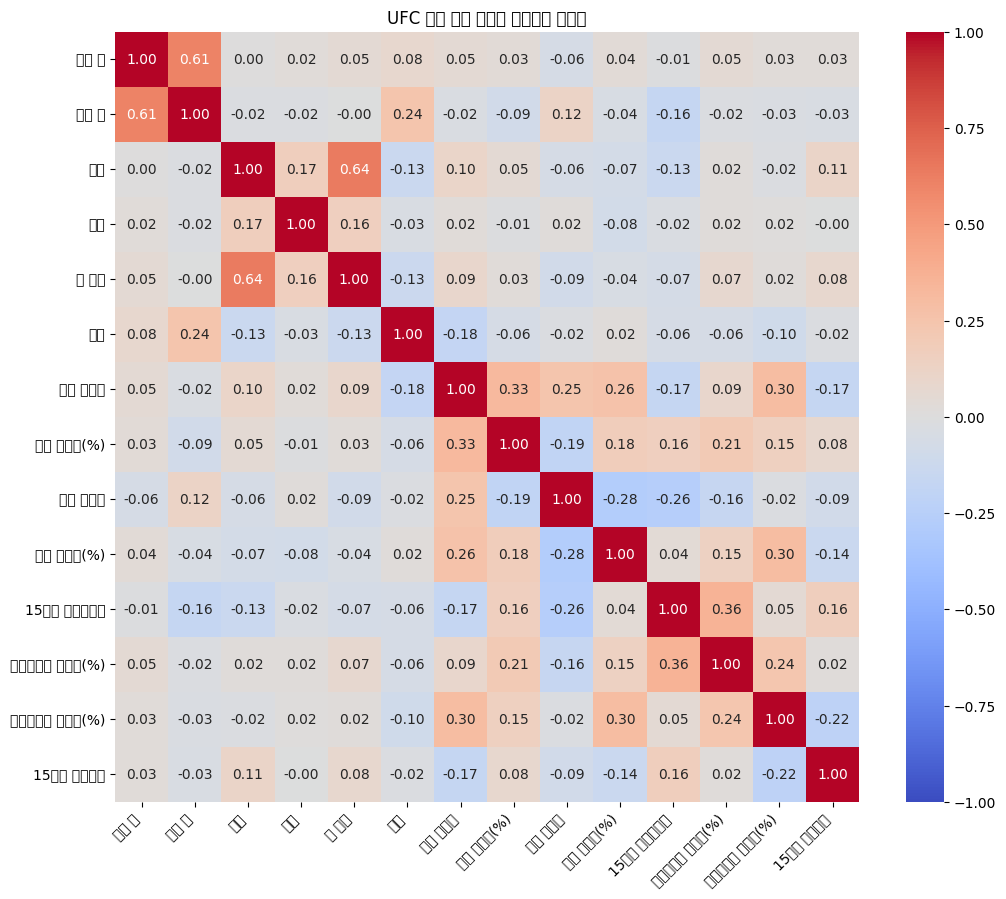

In [4]:
numeric_features = [
    'wins_diff', 
    'losses_diff', 
    'height_diff',
    'weight_diff',
    'reach_diff',
    'age_diff',
    'splm_diff',
    'str_acc_diff',
    'sapm_diff',
    'str_def_diff',
    'td_avg_diff', 
    'td_acc_diff', 
    'td_def_diff', 
    'sub_avg_diff'
    ]

feature_korean_names = {
    'wins_diff': '승리 수',
    'losses_diff': '패배 수',
    'height_diff': '신장',
    'weight_diff': '체중',
    'reach_diff': '팔 길이',
    'age_diff': '나이',
    'splm_diff': '분당 유효타',
    'str_acc_diff': '타격 정확도(%)',
    'sapm_diff': '분당 피격타',
    'str_def_diff': '타격 방어율(%)',
    'td_avg_diff': '15분당 테이크다운',
    'td_acc_diff': '테이크다운 정확도(%)',
    'td_def_diff': '테이크다운 방어율(%)',
    'sub_avg_diff': '15분당 서브미션'}

corr = df[numeric_features].rename(columns=feature_korean_names).corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr, annot=True, cmap='coolwarm',vmin=-1, vmax=1, fmt=".2f")

plt.title('UFC 선수 특성 차이의 상관관계 히트맵')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.show()